In [140]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import plotly as py
from chart_studio.plotly import plot_mpl
import plotly.graph_objects as go

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from pmdarima import arima
from pmdarima.arima import auto_arima
from pmdarima import pipeline, preprocessing as ppc, utils

%matplotlib inline

In [13]:
def sarima_fit_predict (train, endog_col, periods, exog_cols = None):
    
    y_train = train[endog_col]
    
    if exog_cols:
        
        exog_train = train[exog_cols]
        
        model = auto_arima(y_train, exogenous= exog_train, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=52,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
        
        print(f"Final AIC: {model.aic()}")
        print(model)
        preds, conf_int = model.predict(n_periods = periods, exogenous = exog_train, return_conf_int = True)
    
    else:
        
        model = auto_arima(y_train, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=52,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
        
        print(f"Final AIC: {model.aic()}")
        print(model)
        preds, conf_int = model.predict(n_periods = periods, return_conf_int = True)
        
    return model, preds, conf_int

In [14]:
def sarima_update(test, split, model):
    
    # We can also call `update` directly on the pipeline object, which will update
    # the intermittent transformers, where necessary:
    observed, val_test = test[:split], test[split:]
    model.update(observed, maxiter=10)
    
    preds, conf = model.predict(n_periods = val_test.shape[0], return_conf_int= True)
    
    return preds, conf, observed, val_test

In [75]:
def plotly_forecast(df, preds, train, test):
    
    # Create traces
    fig = go.Figure()

    n_train = train.shape[0]
    x = np.arange(n_train + preds.shape[0])

    fig.add_trace(go.Scatter(x= df.index[n_train:], y= preds,
                    mode='lines+markers',
                    name='Predicted'))

    fig.add_trace(go.Scatter(x= df.index[n_train:], y= test[:preds.shape[0]],
                    mode='lines+markers',
                    name='Actual'))


    fig.show()

# Moraine Park, Rocky Mountain National Park
---

In [189]:
moraine = pd.read_csv( "../data/Site-Data/moraine_agg.csv")

In [190]:
moraine['Date'] = pd.to_datetime(moraine['Date']) - pd.to_timedelta(7, unit='d')
moraine.index = pd.DatetimeIndex(moraine['Date'])
moraine = moraine.groupby([pd.Grouper(key='Date', freq='W-MON')]).mean().sort_values('Date')
moraine.head()

,FacilityID,Reservations,NumberOfPeople,SitesBooked,AvgStayLen,AvgBookingHorizon,AverageFee,DailyRevenue,SumHor,SumLen,SumFee,SitesAvailable,PercentBooked
Date,,,,,,,,,,,,,
2014-05-19,232463.0,225.200000,766.000000,149.000000,3.242773,59.978610,30.365414,2368.088086,14203.399551,733.200004,6830.000014,102.000000,0.593625
2014-05-26,232463.0,195.571429,616.714286,148.714286,3.538806,48.377871,38.719400,2181.585013,9670.571438,684.714282,7507.142780,102.285714,0.592487
2014-06-02,232463.0,263.285714,794.285714,183.000000,3.573867,54.106416,36.268623,2816.787423,15040.285890,930.142854,9288.571557,68.000000,0.729084
2014-06-09,232463.0,367.000000,1050.714286,235.714286,3.526888,55.617553,36.648424,3994.855399,20875.285633,1287.999992,13364.285431,15.285714,0.939101
2014-06-16,232463.0,321.571429,1075.428571,197.857143,3.711821,76.349417,40.272182,3617.644531,24702.999919,1191.428576,12917.142714,53.142857,0.788275


In [191]:
#py.tools.set_credentials_file(username= 'templecm4y', api_key= 'sZiFEGF0iOEDu94PXYKa')

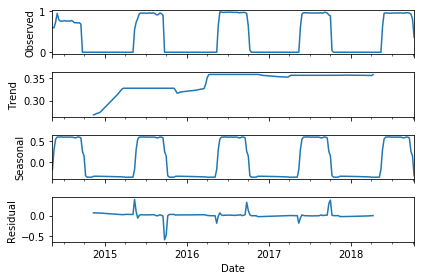

In [192]:
result = seasonal_decompose(moraine['PercentBooked'], model='additive')
fig = result.plot()

In [193]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=moraine.index, y=moraine['PercentBooked'],
                mode='lines',
                name='lines'))

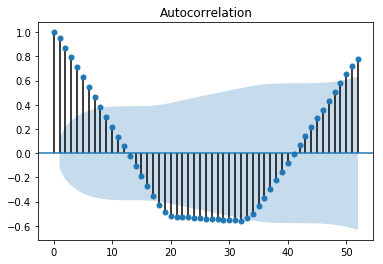

In [194]:
# autocorrelation plot
plot_acf(moraine['PercentBooked'], lags = 52);

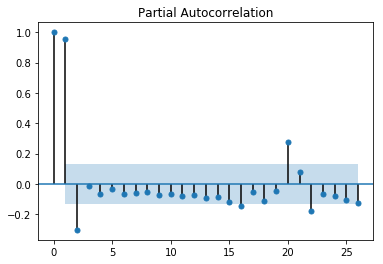

In [195]:
# partial autocorrelaion plot
plot_pacf(moraine['PercentBooked'], lags = 26);

In [232]:
train, test = moraine[:170], moraine[170:]

y_train, y_test = train['PercentBooked'], test['PercentBooked']
exog_train = train[['Reservations', 'NumberOfPeople', 'AvgStayLen', 'AvgBookingHorizon', 'DailyRevenue']]
exog_test = test[['Reservations', 'NumberOfPeople', 'AvgStayLen', 'AvgBookingHorizon', 'DailyRevenue']]

In [233]:
#ff = ppc.FourierFeaturizer(m=52)
#y_train, exog_train = ff.fit_transform(y_train, exog_train)

In [234]:
stepwise_model, preds, conf_int = sarima_fit_predict(train, 'PercentBooked', 60)

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 52); AIC=-145.415, BIC=-139.891, Fit time=0.624 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 52); AIC=-143.847, BIC=-132.798, Fit time=6.424 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 0, 52); AIC=-144.433, BIC=-136.147, Fit time=2.631 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 0, 52); AIC=-144.891, BIC=-136.604, Fit time=1.243 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 52); AIC=-151.510, BIC=-143.223, Fit time=0.768 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 1, 0, 52); AIC=-174.413, BIC=-

In [251]:
new_preds, new_conf, newly_observed, still_test = sarima_update(y_test, 30, pipe.named_steps['model'])

In [252]:
def series_forecast_plot(train, test, preds, conf_int, observed, val_preds, val_conf, val_test):
    fig, axes = plt.subplots(2, 1, figsize=(20, 12))
    
    lim = train.shape[0] + test.shape[0]
    n_train = train.shape[0]
    x = np.arange(n_train + preds.shape[0])

    axes[0].plot(x[:n_train], train, alpha=0.75)
    axes[0].scatter(x[n_train:], preds, alpha=0.4, marker='o')
    axes[0].scatter(x[n_train:], test[:preds.shape[0]], alpha=0.4, marker='x')
    axes[0].fill_between(x[n_train:], conf_int[:, 0], conf_int[:, 1],
                         alpha=0.1, color='b')
    axes[0].set_title('Actual test samples vs. forecasts')
    axes[0].set_xlim((0, lim))

    x2 = np.arange(lim)
    n_trained_on = n_train + newly_observed.shape[0]

    axes[1].plot(x2[:n_train], train, alpha=0.75)
    axes[1].plot(x2[n_train: n_trained_on], observed, alpha=0.75, c='orange')
    axes[1].scatter(x2[n_trained_on:], val_preds, alpha=0.4, marker='o')
    axes[1].scatter(x2[n_trained_on:], val_test, alpha=0.4, marker='x')
    axes[1].fill_between(x2[n_trained_on:], val_conf[:, 0], val_conf[:, 1],
                         alpha=0.1, color='b')
    axes[1].set_title('Updated test samples vs. forecasts')
    axes[1].set_xlim((0, lim))

    plt.show()

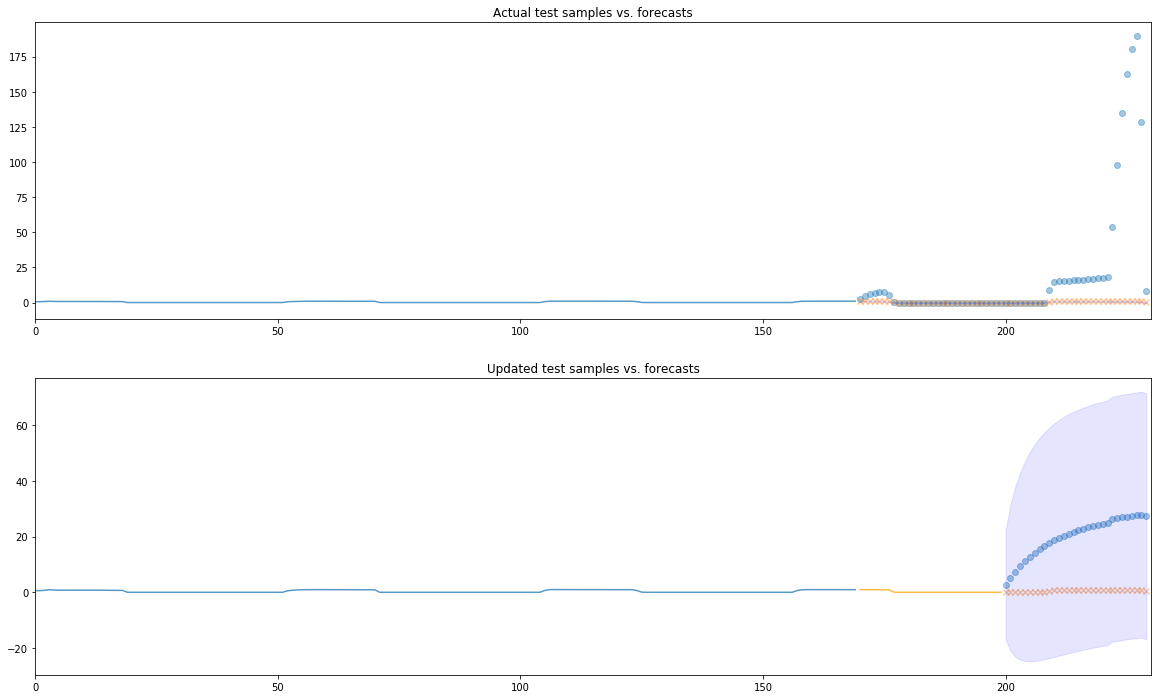

In [253]:
series_forecast_plot(y_train, y_test, preds, conf_int, newly_observed, new_preds, new_conf, still_test)

In [254]:
plotly_forecast(moraine, preds, y_train, y_test)

In [67]:
# fit on total samples and generate predicitons
stepwise_model.fit(moraine['PercentBooked'])
preds, conf_int = stepwise_model.predict(n_periods = 104, return_conf_int= True)

In [68]:
def zero_lim (arr):
    zl = lambda a: (abs(a) + a)/2
    zfunc = np.vectorize(zl)
    return zfunc(arr)

In [69]:
lim_preds = zero_lim(preds)

(200, 334)

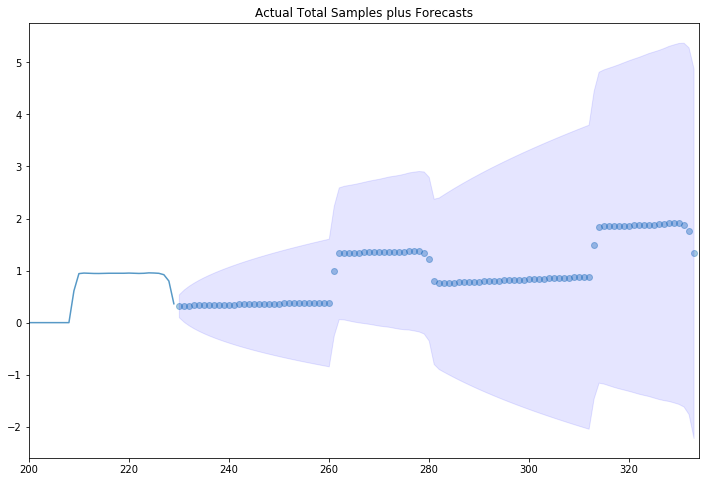

In [70]:
fig = plt.figure(figsize=(12, 8))

n_train = moraine['PercentBooked'].shape[0]
x = np.arange(n_train + preds.shape[0])
plt.plot(x[:n_train], moraine['PercentBooked'], alpha=0.75)
plt.scatter(x[n_train:], lim_preds, alpha=0.4, marker='o')
plt.fill_between(x[n_train:], conf_int[:, 0], conf_int[:, 1],
                     alpha=0.1, color='b')

plt.title('Actual Total Samples plus Forecasts')
plt.xlim((200, moraine.shape[0] + preds.shape[0]))

# Mather Campground, Grand Canyon National Park
---

In [77]:
mather = pd.read_csv( "../data/Site-Data/mather_agg.csv")

In [78]:
mather['Date'] = pd.to_datetime(mather['Date']) - pd.to_timedelta(7, unit='d')
mather.index = pd.DatetimeIndex(mather['Date'])
mather = mather[mather.index < '2019-01-01']
mather = mather.groupby([pd.Grouper(key='Date', freq='W-MON')]).mean().sort_values('Date')
mather.head()

,FacilityID,Reservations,NumberOfPeople,SitesBooked,AvgStayLen,AvgBookingHorizon,AverageFee,DailyRevenue,SumHor,SumLen,SumFee,SitesAvailable,PercentBooked
Date,,,,,,,,,,,,,
2013-09-30,232490.0,0.333333,0.333333,0.333333,0.666667,0.333333,6.000000,3.000000,0.333333,0.666667,6.000000,118.666667,0.000934
2013-10-07,232490.0,50.285714,119.142857,44.857143,1.028256,0.004900,10.084288,474.802037,0.714286,121.285716,1188.000008,108.142857,0.125650
2013-10-14,232490.0,175.571429,509.142857,147.428571,2.670648,0.232833,26.653030,1695.064279,40.857142,468.714290,4679.571433,209.571429,0.412965
2013-10-21,232490.0,174.000000,457.857143,144.428571,2.804204,1.019163,27.970174,1710.046596,181.142857,487.857142,4869.428588,212.571429,0.404562
2013-10-28,232490.0,112.000000,269.857143,99.571429,2.781567,2.314576,28.747663,1142.918692,258.571425,311.285716,3216.285692,257.428571,0.278912


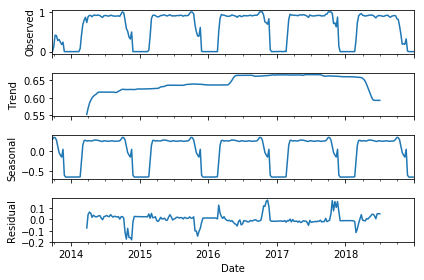

In [79]:
result = seasonal_decompose(mather['PercentBooked'], model='additive')
fig = result.plot()

In [97]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=mather.index, y=mather['PercentBooked'],
                mode='lines',
                name='lines'))

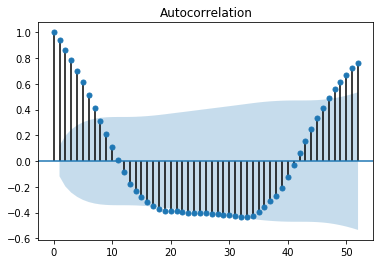

In [81]:
# autocorrelation plot
plot_acf(mather['PercentBooked'], lags = 52);

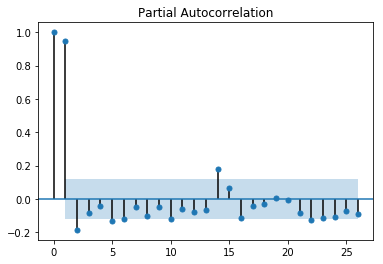

In [82]:
# partial autocorrelaion plot
plot_pacf(mather['PercentBooked'], lags = 26);

In [83]:
mather.shape

(275, 13)

In [84]:
train, test = mather[:215], mather[215:]

y_train, y_test = train['PercentBooked'], test['PercentBooked']
exog_train = train[['Reservations', 'NumberOfPeople', 'AvgStayLen', 'AvgBookingHorizon', 'DailyRevenue']]
exog_test = test[['Reservations', 'NumberOfPeople', 'AvgStayLen', 'AvgBookingHorizon', 'DailyRevenue']]

In [85]:
stepwise_model, preds, conf_int = sarima_fit_predict(train, 'PercentBooked', 60)

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 52); AIC=-454.969, BIC=-448.794, Fit time=0.763 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 52); AIC=-451.555, BIC=-439.205, Fit time=2.993 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 0, 52); AIC=-453.011, BIC=-443.748, Fit time=7.273 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 1, 52); AIC=-450.971, BIC=-438.620, Fit time=6.559 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 0, 52); AIC=-453.527, BIC=-444.264, Fit time=2.064 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 52); AIC=-453.521, BIC=-444.258, Fit time=2.168 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 52); AIC=nan

In [86]:
new_preds, new_conf, newly_observed, still_test = sarima_update(y_test, 30, stepwise_model)

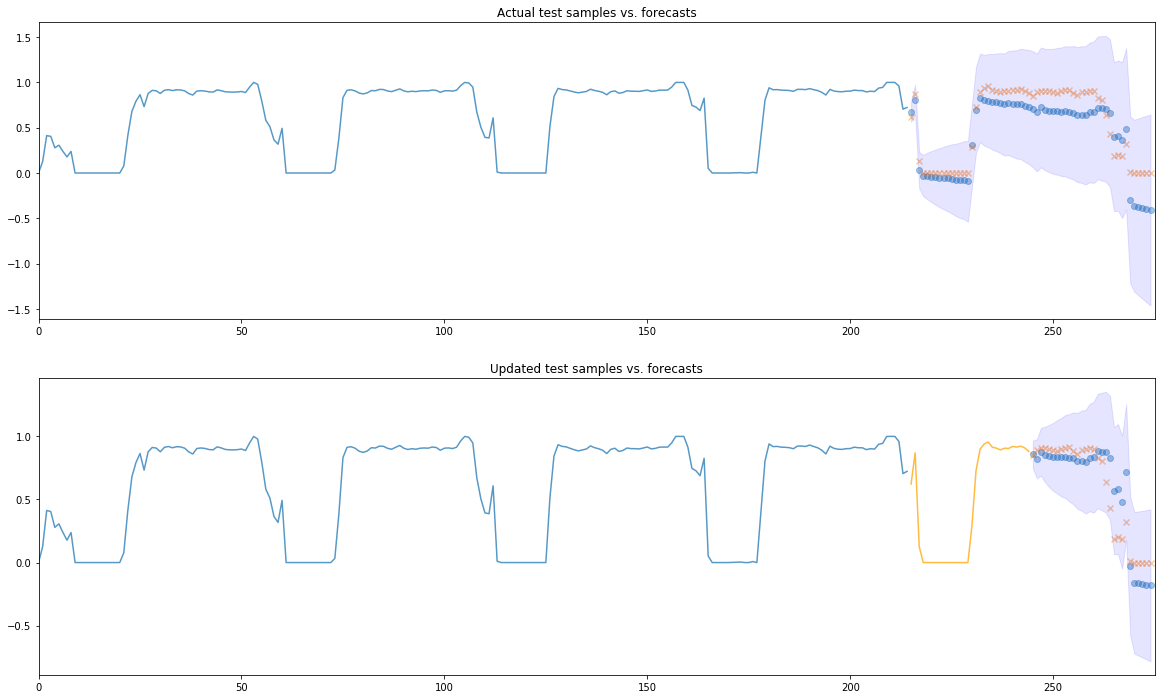

In [87]:
series_forecast_plot(y_train, y_test, preds, conf_int, newly_observed, new_preds, new_conf, still_test)

In [88]:
plotly_forecast(mather, preds, y_train, y_test)

In [89]:
# fit on total samples and generate predicitons
stepwise_model.fit(mather['PercentBooked'])
preds, conf_int = stepwise_model.predict(n_periods = 104, return_conf_int= True)

In [90]:
lim_preds = zero_lim(preds)

(200, 379)

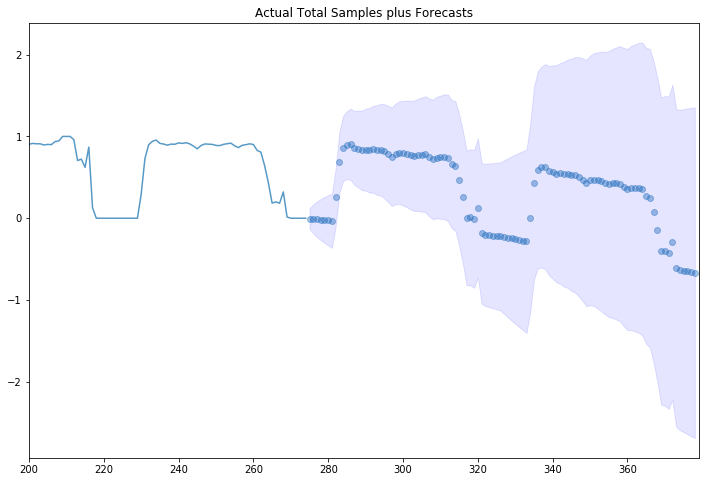

In [91]:
fig = plt.figure(figsize=(12, 8))

n_train = mather['PercentBooked'].shape[0]
x = np.arange(n_train + preds.shape[0])
plt.plot(x[:n_train], mather['PercentBooked'], alpha=0.75)
plt.scatter(x[n_train:], preds, alpha=0.4, marker='o')
plt.fill_between(x[n_train:], conf_int[:, 0], conf_int[:, 1],
                     alpha=0.1, color='b')

plt.title('Actual Total Samples plus Forecasts')
plt.xlim((200, mather.shape[0] + preds.shape[0]))

# Big Meadow Campground, Shenandoah National Park
---

In [92]:
big_meadow = pd.read_csv( "../data/Site-Data/bigmeadow_agg.csv")

In [93]:
big_meadow['Date'] = pd.to_datetime(big_meadow['Date']) - pd.to_timedelta(7, unit='d')
big_meadow.index = pd.DatetimeIndex(big_meadow['Date'])
big_meadow = big_meadow[big_meadow.index < '2019-01-01']
big_meadow = big_meadow.groupby([pd.Grouper(key='Date', freq='W-MON')]).mean().sort_values('Date')
big_meadow.head()

,FacilityID,Reservations,NumberOfPeople,SitesBooked,AvgStayLen,AvgBookingHorizon,AverageFee,DailyRevenue,SumHor,SumLen,SumFee,SitesAvailable,PercentBooked
Date,,,,,,,,,,,,,
2013-09-30,232459.0,0.500000,2.500000,0.500000,1.000000,1.500000,0.000000,0.000000,1.500000,1.000000,0.000000,110.000000,0.002262
2013-10-07,232459.0,0.571429,3.428571,0.571429,0.571429,2.857143,0.000000,0.000000,5.714286,1.142857,0.000000,62.571429,0.002586
2013-10-14,232459.0,13.571429,38.428571,13.428571,1.181791,1.237851,12.784477,138.231295,34.428571,33.571429,354.285721,81.285714,0.060763
2013-10-21,232459.0,31.142857,82.142857,28.714286,3.153725,4.489710,33.828847,340.042520,136.857143,90.142857,952.857155,192.285714,0.129929
2013-10-28,232459.0,56.000000,184.142857,53.571429,3.199183,7.162628,32.432571,598.869049,415.857151,154.142860,1627.142860,167.428571,0.242405


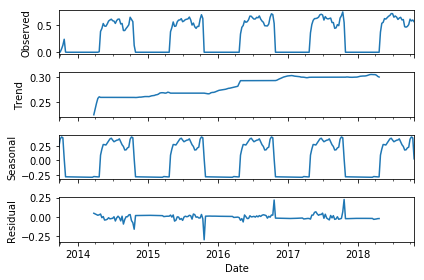

In [94]:
result = seasonal_decompose(big_meadow['PercentBooked'], model='additive')
fig = result.plot()

In [96]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=big_meadow.index, y=big_meadow['PercentBooked'],
                mode='lines',
                name='lines'))

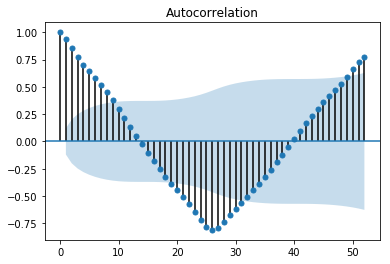

In [98]:
# autocorrelation plot
plot_acf(big_meadow['PercentBooked'], lags = 52);

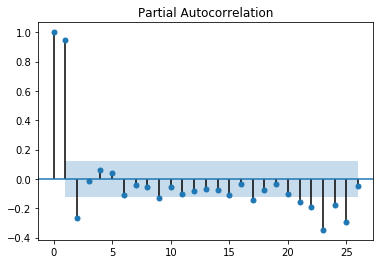

In [99]:
# partial autocorrelaion plot
plot_pacf(big_meadow['PercentBooked'], lags = 26);

In [100]:
big_meadow.shape

(265, 13)

In [101]:
train, test = big_meadow[:205], big_meadow[205:]

y_train, y_test = train['PercentBooked'], test['PercentBooked']
exog_train = train[['Reservations', 'NumberOfPeople', 'AvgStayLen', 'AvgBookingHorizon', 'DailyRevenue']]
exog_test = test[['Reservations', 'NumberOfPeople', 'AvgStayLen', 'AvgBookingHorizon', 'DailyRevenue']]

In [103]:
stepwise_model, preds, conf_int = sarima_fit_predict(train, 'PercentBooked', 60)

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 52); AIC=-313.899, BIC=-307.851, Fit time=0.733 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 52); AIC=-326.434, BIC=-314.338, Fit time=10.054 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 0, 52); AIC=-326.873, BIC=-317.801, Fit time=0.642 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(0, 1, 0, 52); AIC=-328.239, BIC=-316.144, Fit time=0.723 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 1, 0, 52); AIC=-329.178, BIC=-314.059, Fit time=2.729 seconds
Fit ARIMA: order=(3, 1, 2) seasonal_order=(0, 1, 0, 52); AIC=nan, BIC=nan, 

In [104]:
new_preds, new_conf, newly_observed, still_test = sarima_update(y_test, 30, stepwise_model)

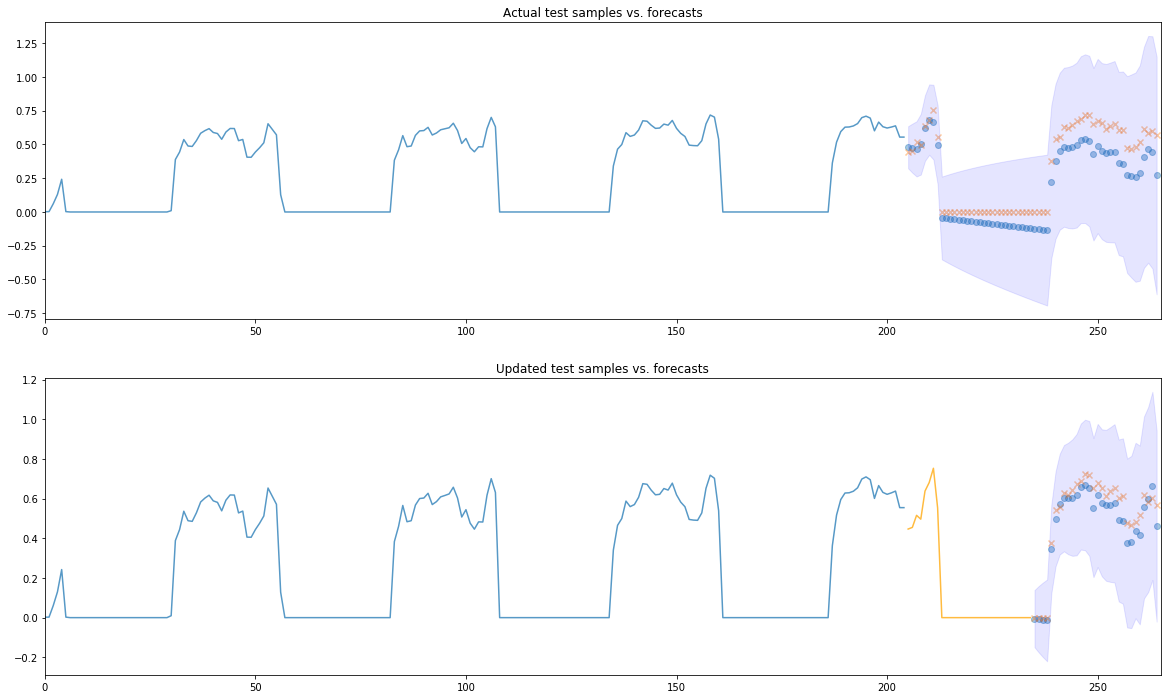

In [105]:
series_forecast_plot(y_train, y_test, preds, conf_int, newly_observed, new_preds, new_conf, still_test)

In [106]:
plotly_forecast(big_meadow, preds, y_train, y_test)

In [107]:
# fit on total samples and generate predicitons
stepwise_model.fit(big_meadow['PercentBooked'])
preds, conf_int = stepwise_model.predict(n_periods = 104, return_conf_int= True)

In [108]:
lim_preds = zero_lim(preds)

(200, 369)

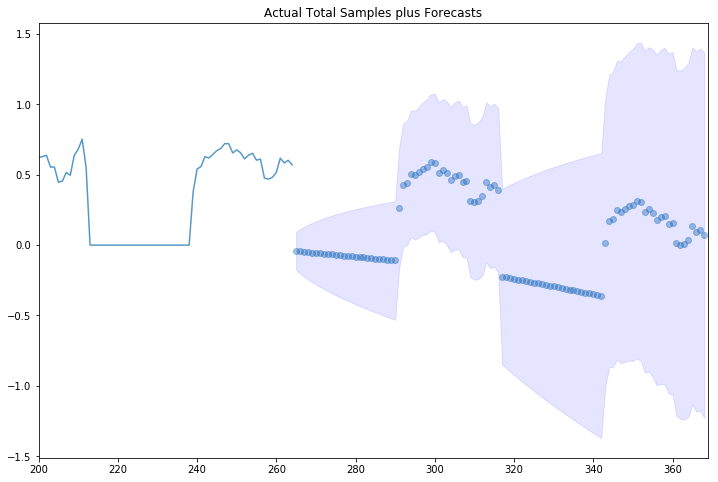

In [109]:
fig = plt.figure(figsize=(12, 8))

n_train = big_meadow['PercentBooked'].shape[0]
x = np.arange(n_train + preds.shape[0])
plt.plot(x[:n_train], big_meadow['PercentBooked'], alpha=0.75)
plt.scatter(x[n_train:], preds, alpha=0.4, marker='o')
plt.fill_between(x[n_train:], conf_int[:, 0], conf_int[:, 1],
                     alpha=0.1, color='b')

plt.title('Actual Total Samples plus Forecasts')
plt.xlim((200, big_meadow.shape[0] + preds.shape[0]))

# Upper Pines Campground, Yosemite National Park
---

In [110]:
upper_pines = pd.read_csv( "../data/Site-Data/upperpines_agg.csv")

In [111]:
upper_pines['Date'] = pd.to_datetime(upper_pines['Date']) - pd.to_timedelta(7, unit='d')
upper_pines.index = pd.DatetimeIndex(upper_pines['Date'])
upper_pines = upper_pines[upper_pines.index < '2019-01-01']
upper_pines = upper_pines.groupby([pd.Grouper(key='Date', freq='W-MON')]).mean().sort_values('Date')
upper_pines.head()

,FacilityID,Reservations,NumberOfPeople,SitesBooked,AvgStayLen,AvgBookingHorizon,AverageFee,DailyRevenue,SumHor,SumLen,SumFee,SitesAvailable,PercentBooked
Date,,,,,,,,,,,,,
2013-09-30,232447.0,1.000000,3.000000,1.000000,0.666667,0.333333,4.444444,6.666667,1.000000,2.000000,13.333333,78.333333,0.004202
2013-10-07,232447.0,0.428571,0.857143,0.428571,1.285714,3.000000,0.000000,0.000000,3.000000,1.285714,0.000000,101.571429,0.001801
2013-10-14,232447.0,76.285714,145.857143,61.714286,1.925305,0.555215,19.796399,787.204065,79.142857,219.285716,2331.428536,108.285714,0.259304
2013-10-21,232447.0,180.285714,347.142857,136.714286,3.046735,2.239072,33.009827,1931.050991,358.428571,552.857150,6041.428649,101.285714,0.574430
2013-10-28,232447.0,162.000000,408.857143,132.142857,3.448719,4.974581,36.812322,1791.896240,854.285708,553.714285,5951.428623,105.857143,0.555222


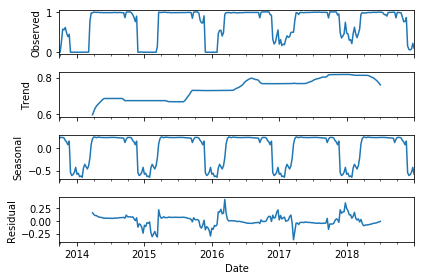

In [112]:
result = seasonal_decompose(upper_pines['PercentBooked'], model='additive')
fig = result.plot()

In [113]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=upper_pines.index, y=upper_pines['PercentBooked'],
                mode='lines',
                name='lines'))

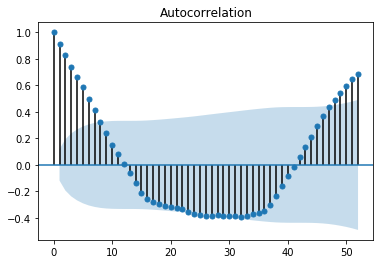

In [114]:
# autocorrelation plot
plot_acf(upper_pines['PercentBooked'], lags = 52);

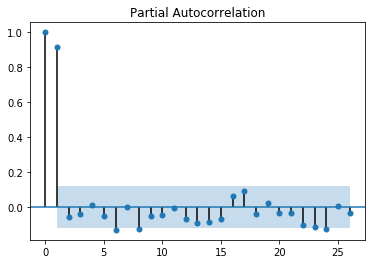

In [115]:
# partial autocorrelaion plot
plot_pacf(upper_pines['PercentBooked'], lags = 26);

In [116]:
upper_pines.shape

(275, 13)

In [117]:
train, test = upper_pines[:215], upper_pines[215:]

y_train, y_test = train['PercentBooked'], test['PercentBooked']
exog_train = train[['Reservations', 'NumberOfPeople', 'AvgStayLen', 'AvgBookingHorizon', 'DailyRevenue']]
exog_test = test[['Reservations', 'NumberOfPeople', 'AvgStayLen', 'AvgBookingHorizon', 'DailyRevenue']]

In [118]:
stepwise_model, preds, conf_int = sarima_fit_predict(train, 'PercentBooked', 60)

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 52); AIC=-171.683, BIC=-165.508, Fit time=0.242 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 52); AIC=-200.902, BIC=-188.551, Fit time=4.924 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 0, 52); AIC=-179.098, BIC=-169.835, Fit time=0.617 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 0, 52); AIC=-200.663, BIC=-185.225, Fit time=17.421 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 0, 52); AIC=-196.747, BIC=-187.484, Fit time=2.904 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(1, 1, 0, 52); AIC=-202.033, BIC=

In [119]:
new_preds, new_conf, newly_observed, still_test = sarima_update(y_test, 30, stepwise_model)

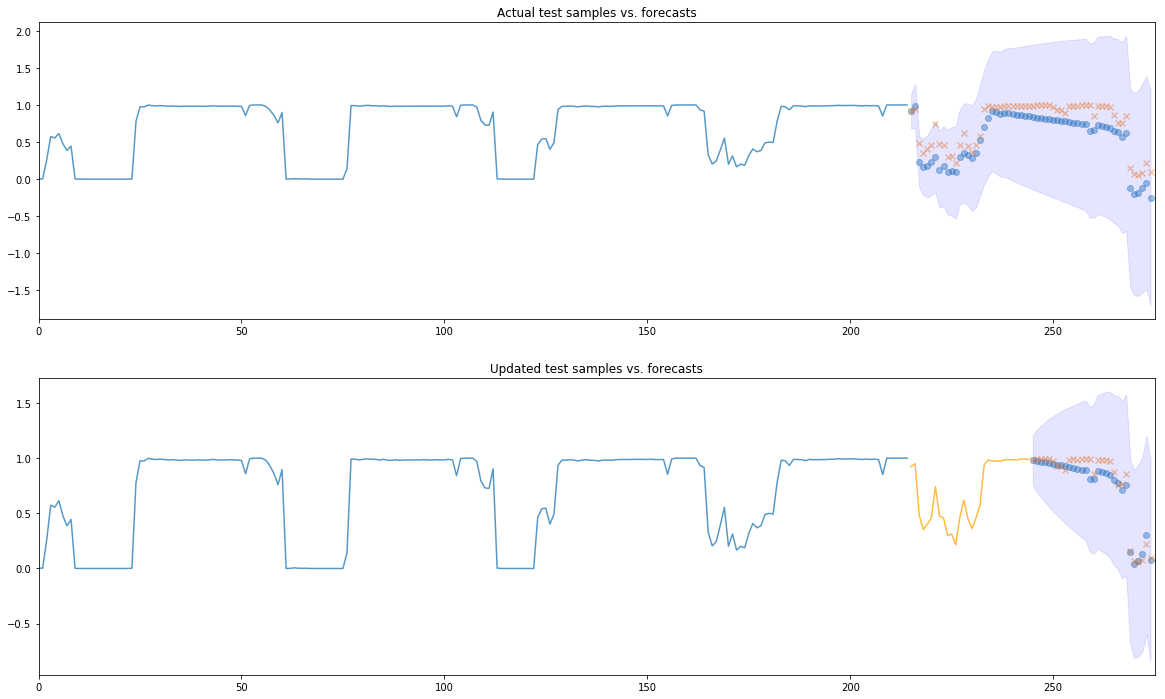

In [120]:
series_forecast_plot(y_train, y_test, preds, conf_int, newly_observed, new_preds, new_conf, still_test)

In [ ]:
plotly_forecast(big_meadow, preds, y_train, y_test)

In [ ]:
# fit on total samples and generate predicitons
stepwise_model.fit(upper_pines['PercentBooked'])
preds, conf_int = stepwise_model.predict(n_periods = 104, return_conf_int= True)

In [ ]:
lim_preds = zero_lim(preds)

In [ ]:
fig = plt.figure(figsize=(12, 8))

n_train = upper_pines['PercentBooked'].shape[0]
x = np.arange(n_train + preds.shape[0])
plt.plot(x[:n_train], upper_pines['PercentBooked'], alpha=0.75)
plt.scatter(x[n_train:], preds, alpha=0.4, marker='o')
plt.fill_between(x[n_train:], conf_int[:, 0], conf_int[:, 1],
                     alpha=0.1, color='b')

plt.title('Actual Total Samples plus Forecasts')
plt.xlim((200, upper_pines.shape[0] + preds.shape[0]))

# Elkmont Campground, Great Smoky Mountains National Park
---

In [ ]:
elkmont = pd.read_csv( "../data/Site-Data/elkmont_agg.csv")

In [ ]:
elkmont['Date'] = pd.to_datetime(elkmont['Date']) - pd.to_timedelta(7, unit='d')
elkmont.index = pd.DatetimeIndex(elkmont['Date'])
elkmont = elkmont[elkmont.index < '2019-01-01']
elkmont = elkmont.groupby([pd.Grouper(key='Date', freq='W-MON')]).mean().sort_values('Date')
elkmont.head()

In [ ]:
result = seasonal_decompose(elkmont['PercentBooked'], model='additive')
fig = result.plot()

In [ ]:
elkmont['PercentBooked'].iplot(theme='pearl')

In [ ]:
# autocorrelation plot
plot_acf(elkmont['PercentBooked'], lags = 52);

In [ ]:
# partial autocorrelation plot
plot_pacf(elkmont['PercentBooked'], lags = 26);

In [ ]:
elkmont.shape

In [ ]:
train, test = elkmont[:205], elkmont[205:]

y_train, y_test = train['PercentBooked'], test['PercentBooked']
exog_train = train[['Reservations', 'NumberOfPeople', 'AvgStayLen', 'AvgBookingHorizon', 'DailyRevenue']]
exog_test = test[['Reservations', 'NumberOfPeople', 'AvgStayLen', 'AvgBookingHorizon', 'DailyRevenue']]

In [ ]:
stepwise_model, preds, conf_int = sarima_fit_predict(train, 'PercentBooked', 60)

In [ ]:
new_preds, new_conf, newly_observed, still_test = sarima_update(y_test, 30, stepwise_model)

In [ ]:
series_forecast_plot(y_train, y_test, preds, conf_int, newly_observed, new_preds, new_conf, still_test)

In [ ]:
# fit on total samples and generate predicitons
stepwise_model.fit(elkmont['PercentBooked'])
preds, conf_int = stepwise_model.predict(n_periods = 104, return_conf_int= True)

In [ ]:
lim_preds = zero_lim(preds)

In [ ]:
fig = plt.figure(figsize=(12, 8))

n_train = elkmont['PercentBooked'].shape[0]
x = np.arange(n_train + preds.shape[0])
plt.plot(x[:n_train], elkmont['PercentBooked'], alpha=0.75)
plt.scatter(x[n_train:], preds, alpha=0.4, marker='o')
plt.fill_between(x[n_train:], conf_int[:, 0], conf_int[:, 1],
                     alpha=0.1, color='b')

plt.title('Actual Total Samples plus Forecasts')
plt.xlim((200, elkmont.shape[0] + preds.shape[0]))

In [ ]:
fig = plt.figure(figsize=(12, 8))

n_train = elkmont['PercentBooked'].shape[0]
x = np.arange(n_train + preds.shape[0])
plt.plot(x[:n_train], elkmont['PercentBooked'], alpha=0.75)
plt.scatter(x[n_train:], preds, alpha=0.4, marker='o')
plt.fill_between(x[n_train:], conf_int[:, 0], conf_int[:, 1],
                     alpha=0.1, color='b')

plt.title('Actual Total Samples plus Forecasts')
plt.xlim((200, elkmont.shape[0] + preds.shape[0]))

In [ ]:
n_train = elkmont['PercentBooked'].shape[0]
x = np.arange(n_train + preds.shape[0])

fig = go.Figure(data=[go.Scatter(x=x[n_train:], y=preds)])
fig.show()